In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from scipy import stats

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

Matplotlib is building the font cache; this may take a moment.


In [2]:
tf.random.set_seed(74)

In [4]:
df = pd.read_csv('../../datasets/data.csv', index_col=['date'], parse_dates=['date'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 192 entries, 2021-09-30 to 2022-07-08
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   work    192 non-null    int64
 1   income  192 non-null    int64
dtypes: int64(2)
memory usage: 4.5 KB


In [6]:
df.columns 

Index(['work', 'income'], dtype='object')

In [7]:
df.head()

,work,income
date,,
2021-09-30,2,2100
2021-10-03,1,3600
2021-10-04,1,4000
2021-10-05,1,7900
2021-10-06,1,7500


In [8]:
df = df.drop(columns=['work'])

In [9]:
df.columns 

Index(['income'], dtype='object')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 192 entries, 2021-09-30 to 2022-07-08
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   income  192 non-null    int64
dtypes: int64(1)
memory usage: 3.0 KB


In [12]:
train_size = int(len(df)*0.75)

train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

In [13]:
scaler = StandardScaler()

train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.fit_transform(test_data)

In [14]:
LOOK_BACK = 30

In [15]:
def create_dataset (X, look_back = 1):
    
    Xs, ys = [], []
 
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])
 
    return np.array(Xs), np.array(ys)

In [16]:
x_train, y_train = create_dataset(train_scaled,LOOK_BACK)
x_test, y_test = create_dataset(test_scaled,LOOK_BACK)

In [17]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(114, 30, 1)
(114, 1)
(18, 30, 1)
(18, 1)


In [18]:
def create_bilstm(units):
    
    model = Sequential()
    # Input layer
    model.add(Bidirectional(
              LSTM(units = units, return_sequences=True), 
              input_shape=(x_train.shape[1], x_train.shape[2])))
    # Hidden layer
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    
    return model

In [19]:
model_bilstm = create_bilstm(64)

In [20]:
model_bilstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 30, 128)          33792     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 132,737
Trainable params: 132,737
Non-trainable params: 0
_________________________________________________________________


In [21]:
def create_gru(units):
    
    model = Sequential()
    
    # Input layer
    model.add(GRU (units = units, return_sequences = True, 
    input_shape = [x_train.shape[1], x_train.shape[2]]))
    model.add(Dropout(0.2)) 
    
    # Hidden layer
    model.add(GRU(units = units)) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    
    #Compile model
    model.compile(optimizer='adam', loss='mse')
    
    return model


In [22]:
model_gru = create_gru(64)

In [23]:
model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 30, 64)            12864     
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 37,889
Trainable params: 37,889
Non-trainable params: 0
_________________________________________________________________


In [24]:
def fit_model(model):
    
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_los',patience = 10)
    
    history = model.fit(x_train, 
                        y_train, 
                        epochs = 200,  
                        validation_split = 0.2,
                        batch_size = 1, 
                        shuffle = False, 
                        callbacks = [early_stop])
    return history

In [25]:
history_bilstm = fit_model(model_bilstm)

Epoch 1/200


91/91 [==============================] - 23s 82ms/step - loss: 0.9437 - val_loss: 0.8028
Epoch 2/200
91/91 [==============================] - 3s 36ms/step - loss: 0.9048 - val_loss: 0.9363
Epoch 3/200
91/91 [==============================] - 3s 37ms/step - loss: 0.8789 - val_loss: 1.2045
Epoch 4/200
91/91 [==============================] - 3s 34ms/step - loss: 0.8610 - val_loss: 1.4191
Epoch 5/200
91/91 [==============================] - 3s 38ms/step - loss: 0.8409 - val_loss: 1.6271
Epoch 6/200
91/91 [==============================] - 3s 36ms/step - loss: 0.8412 - val_loss: 1.9708
Epoch 7/200
91/91 [==============================] - 3s 36ms/step - loss: 0.8059 - val_loss: 2.6284
Epoch 8/200
91/91 [==============================] - 3s 35ms/step - loss: 0.7844 - val_loss: 3.1091
Epoch 9/200
91/91 [==============================] - 3s 35ms/step - loss: 0.7691 - val_loss: 3.1572
Epoch 10/200
91/91 [==============================] - 3s 37ms/step - loss: 0.7486 - val_loss: 3.0258
Epoch 11/2

In [26]:
history_gru = fit_model(model_gru)

Epoch 1/200
91/91 [==============================] - 16s 61ms/step - loss: 0.9883 - val_loss: 0.7897
Epoch 2/200
91/91 [==============================] - 3s 35ms/step - loss: 0.9552 - val_loss: 0.7665
Epoch 3/200
91/91 [==============================] - 3s 37ms/step - loss: 0.9515 - val_loss: 0.7665
Epoch 4/200
91/91 [==============================] - 4s 39ms/step - loss: 0.9318 - val_loss: 0.7698
Epoch 5/200
91/91 [==============================] - 3s 35ms/step - loss: 0.9303 - val_loss: 0.7687
Epoch 6/200
91/91 [==============================] - 3s 38ms/step - loss: 0.9320 - val_loss: 0.7748
Epoch 7/200
91/91 [==============================] - 3s 34ms/step - loss: 0.9281 - val_loss: 0.7816
Epoch 8/200
91/91 [==============================] - 3s 35ms/step - loss: 0.9183 - val_loss: 0.7721
Epoch 9/200
91/91 [==============================] - 3s 34ms/step - loss: 0.9400 - val_loss: 0.7860
Epoch 10/200
91/91 [==============================] - 3s 34ms/step - loss: 0.9062 - val_loss: 0.805

In [27]:
y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

In [28]:
def plot_loss (history, model_name):
    
    plt.figure(figsize = (10, 6))
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    
    plt.title('Model Train vs Validation Loss for ' + model_name)
    
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

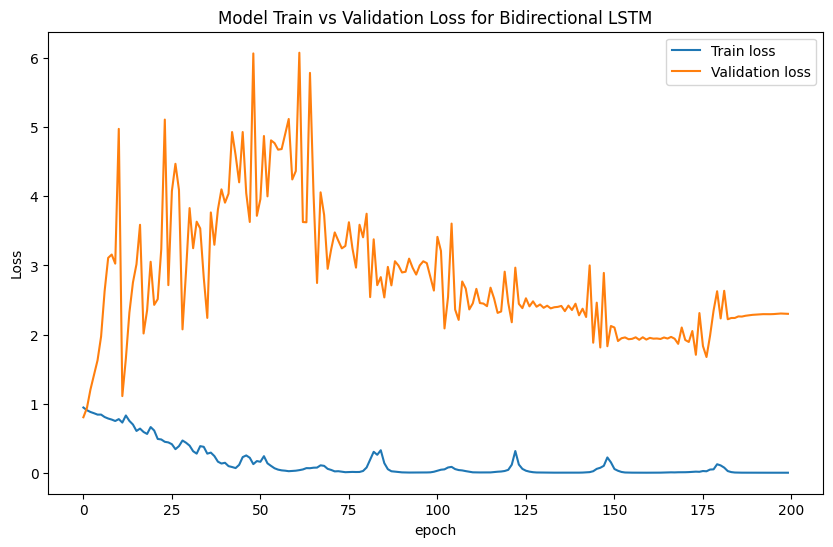

In [29]:
plot_loss(history_bilstm, 'Bidirectional LSTM')

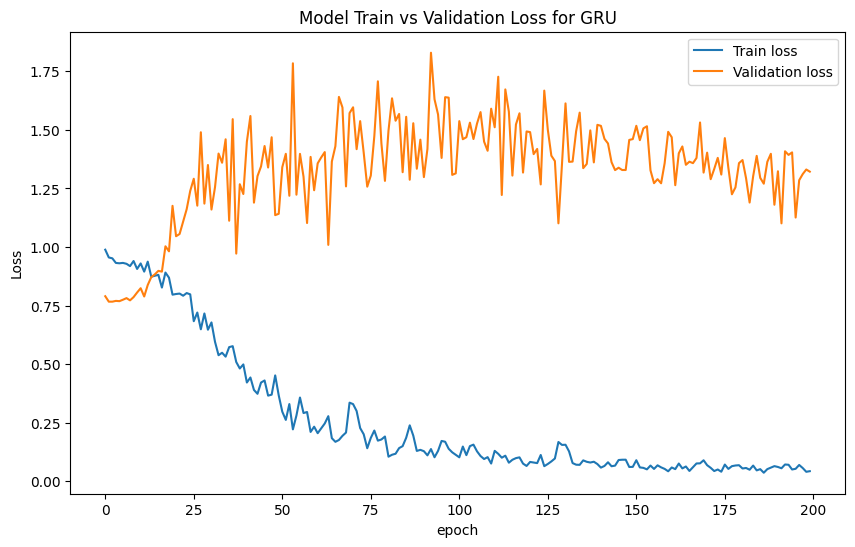

In [30]:
plot_loss(history_gru, 'GRU')

In [31]:
def prediction(model):
    
    prediction = model.predict(x_test)
    prediction = scaler.inverse_transform(prediction)
    
    return prediction

In [32]:
prediction_bilstm = prediction(model_bilstm)

1/1 [==============================] - 4s 4s/step


In [33]:
prediction_gru = prediction(model_gru)

1/1 [==============================] - 2s 2s/step


In [34]:
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)
    
    plt.plot(np.arange(range_future), np.array(y_test), label='Test   data')
    plt.plot(np.arange(range_future), np.array(prediction), label='Prediction')
    
    plt.title('Test data vs prediction for '+ model_name)
    
    plt.legend(loc='upper left')
    plt.xlabel('Time')
    plt.ylabel('income')

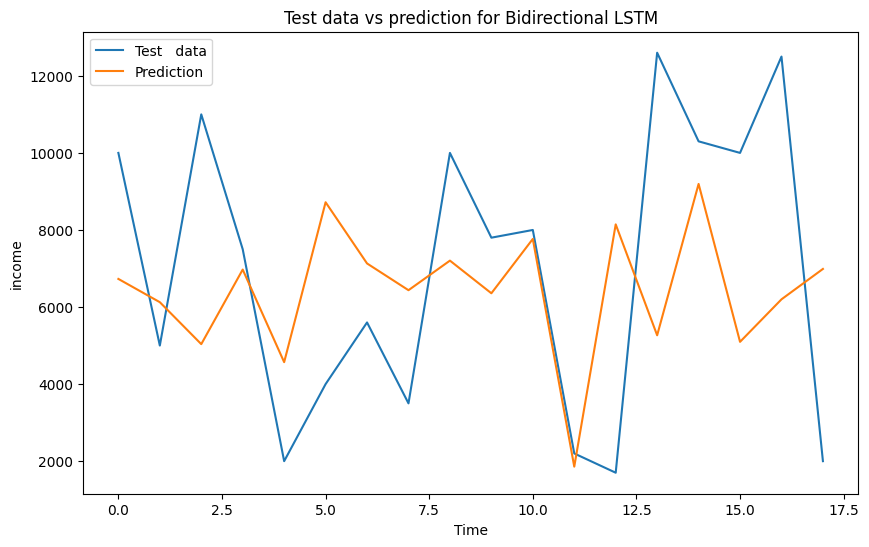

In [35]:
plot_future(prediction_bilstm, 'Bidirectional LSTM', y_test)

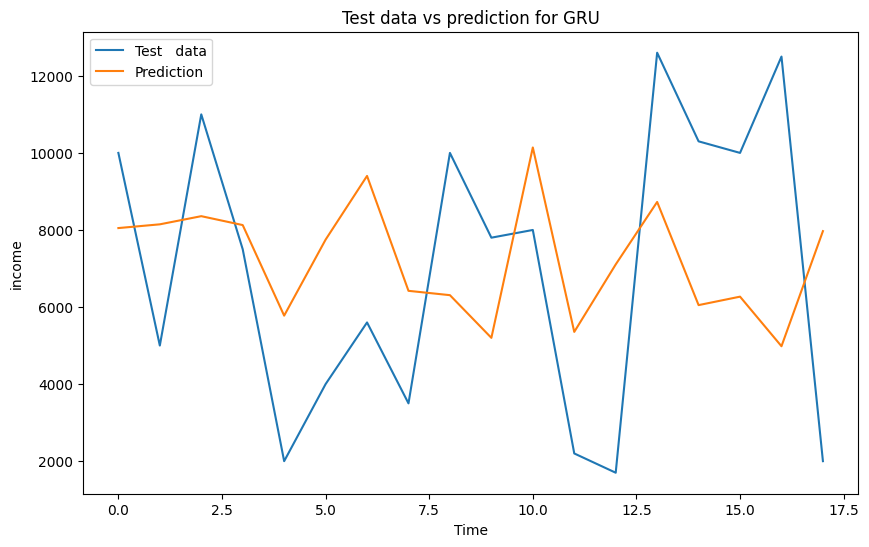

In [36]:
plot_future(prediction_gru, 'GRU', y_test)

In [37]:
def evaluate_prediction(predictions, actual, model_name):
    
    errors = predictions - actual
    
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    
    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')

In [38]:
evaluate_prediction(prediction_bilstm, y_test, 'Bidirectiona LSTM')

Bidirectiona LSTM:
Mean Absolute Error: 3251.8700
Root Mean Square Error: 3964.2377



In [39]:
evaluate_prediction(prediction_gru, y_test, 'GRU')

GRU:
Mean Absolute Error: 3608.2804
Root Mean Square Error: 3913.3844

